## Rain prediction in Australia

#### Import required libraries

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import sklearn

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.impute import SimpleImputer

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

import optuna

import xgboost as xgb
from xgboost import XGBClassifier

import joblib

<br>
<br>
<br>
<br>
<br>

#### Read dataset

In [20]:
dataframe_clean_wo_outl_wo_corr = pd.read_csv(r"C:\Users\Lucio\Documents\Github\Next-day-rain-prediction\1- Data\2- Processed\dataframe_clean_wo_outl_wo_corr.csv", index_col=0)
dataframe_clean_wo_outl_wo_corr.head()

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Humidity9am,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,Albury,0.6,W,44.0,W,WNW,71.0,22.0,1007.7,0.0,0.0
1,Albury,0.0,WNW,44.0,NNW,WSW,44.0,25.0,1010.6,0.0,0.0
2,Albury,0.0,WSW,46.0,W,WSW,38.0,30.0,1007.6,0.0,0.0
3,Albury,0.0,NE,24.0,SE,E,45.0,16.0,1017.6,0.0,0.0
4,Albury,1.0,W,41.0,ENE,NW,82.0,33.0,1010.8,0.0,0.0


dataframe_clean_wo_outl_wo_corr characteristics:
- Removed univariated outliers
- Removed variables with high collinearity

<br>
<br>
<br>
<br>
<br>

#### Encode Categorical Features

In [21]:
dataframe_encoded = pd.get_dummies(dataframe_clean_wo_outl_wo_corr)
dataframe_encoded.head()

,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,RainToday,RainTomorrow,Location_Adelaide,Location_Albany,Location_Albury,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.6,44.0,71.0,22.0,1007.7,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.0,44.0,44.0,25.0,1010.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.0,46.0,38.0,30.0,1007.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.0,24.0,45.0,16.0,1017.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,41.0,82.0,33.0,1010.8,0.0,0.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


<br>
<br>
<br>
<br>
<br>

## Model Tranining

#### Create X and y dataframes

In [22]:
X = dataframe_encoded[[c for c in dataframe_encoded if c != 'RainTomorrow']].values
y = dataframe_encoded[['RainTomorrow']]

In [23]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y,random_state=42, test_size=0.30)

#### Applying StandardScaler

In [24]:
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()
X_sc = sc_X.fit_transform(X)
y_sc = sc_y.fit_transform(y)

In [25]:
X_sc_train, X_sc_val, y_sc_train, y_sc_val = sklearn.model_selection.train_test_split(X_sc, y_sc, random_state=42, test_size=0.30)

#### Applying SMOTE

In [26]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_sc_train, y_train)

<br>
<br>
<br>
<br>
<br>

#### Define optimization function

def objective_xgb(trial):
    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'eval_metric': 'error',
    }

    #param["booster"] == "gbtree"
    param["subsample"] = trial.suggest_float("subsample", 1e-8, 1.0, log=True)
    param["n_estimators"] = trial.suggest_int("n_estimators", 1, 1000)        
    param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    ratio_majority_to_minority = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  #Adjust weights based on rain/no-rain proportion
    
    bst = xgb.XGBClassifier(**param, scale_pos_weight=ratio_majority_to_minority)
    bst.fit(X_train, y_train)

    y_pred = bst.predict(X_val)
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

    return -accuracy  #Negative accuracy to maximize it (because 'eval_metric': 'error')

In [27]:
def objective_xgb(trial):
    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'eval_metric': 'error',
    }

    #param["booster"] == "gbtree"
    param["subsample"] = trial.suggest_float("subsample", 1e-8, 1.0, log=True)
    param["n_estimators"] = trial.suggest_int("n_estimators", 1, 1000)        
    param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    ratio_majority_to_minority = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])  # Ajustar pesos basados en la proporción de lluvia/no-lluvia
    
    bst = xgb.XGBClassifier(**param, scale_pos_weight=ratio_majority_to_minority)
    bst.fit(X_train_resampled, y_train_resampled)

    y_pred = bst.predict(X_sc_val)
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

    return -accuracy  # Precisión negativa para maximizarla (debido a 'eval_metric': 'error')

#### Hyperparameter optimization with Optuna

In [28]:
study_xgb = optuna.create_study()
study_xgb.optimize(objective_xgb, n_trials=10) #n_trials sugerido -> 50
study_xgb.best_params

[I 2023-11-23 21:34:11,545] A new study created in memory with name: no-name-a6f4cf8c-93db-444c-a257-12936039630e
[I 2023-11-23 21:34:19,435] Trial 0 finished with value: -0.7784811578247207 and parameters: {'booster': 'gbtree', 'lambda': 2.1673646034977568e-07, 'alpha': 0.013994342126261232, 'subsample': 1.7010467099522647e-06, 'n_estimators': 102, 'max_depth': 41, 'eta': 0.00015469206602825443, 'gamma': 4.260840761106149e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -0.7784811578247207.
[W 2023-11-23 21:52:58,001] Trial 1 failed with parameters: {'booster': 'gbtree', 'lambda': 4.88198577699375e-07, 'alpha': 0.00036307520265838403, 'subsample': 0.4514367527130117, 'n_estimators': 586, 'max_depth': 48, 'eta': 2.0761588734175483e-07, 'gamma': 0.43995639472444353, 'grow_policy': 'depthwise'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Lucio\miniconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _r

KeyboardInterrupt: 

In [29]:
xgb_params = study_xgb.best_params
xgb_params

{'booster': 'gbtree',
 'lambda': 2.1673646034977568e-07,
 'alpha': 0.013994342126261232,
 'subsample': 1.7010467099522647e-06,
 'n_estimators': 102,
 'max_depth': 41,
 'eta': 0.00015469206602825443,
 'gamma': 4.260840761106149e-06,
 'grow_policy': 'depthwise'}

#### Train model using best parameters
Adjust weights based on rain/no-rain proportion

In [30]:
ratio_majority_to_minority = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])  # Ajustar pesos basados en la proporción de lluvia/no-lluvia

model = XGBClassifier(**xgb_params, silent=0, scale_pos_weight=ratio_majority_to_minority)

model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_sc_val, y_sc_val)], early_stopping_rounds=10, verbose=True)

C:\Users\Lucio\miniconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21:53:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.69315
[1]	validation_0-logloss:0.69315
[2]	validation_0-logloss:0.69315
[3]	validation_0-logloss:0.69315
[4]	validation_0-logloss:0.69315
[5]	validation_0-logloss:0.69315
[6]	validation_0-logloss:0.69315
[7]	validation_0-logloss:0.69315
[8]	validation_0-logloss:0.69315
[9]	validation_0-logloss:0.69315


XGBClassifier(alpha=0.013994342126261232, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.00015469206602825443,
              eval_metric=None, gamma=4.260840761106149e-06, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.1673646034977568e-07,
              learning_rate=0.000154692068, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=41, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=102,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

#### Predict using validation dataset

In [31]:
y_predicted = model.predict(X_sc_val)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

#### Model performance evaluation

In [32]:
conf_matrix = confusion_matrix(y_val, y_predicted)

accuracy = accuracy_score(y_val, y_predicted)
precision = precision_score(y_val, y_predicted)
recall = recall_score(y_val, y_predicted)
f1 = f1_score(y_val, y_predicted)
roc_auc = roc_auc_score(y_val, y_predicted)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC:", roc_auc)

Confusion Matrix:
 [[33941     0]
 [ 9658     0]]
Accuracy: 0.7784811578247207
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC AUC: 0.5


C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    '''
    This function plots
    confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [35]:
def plot_classification_report(y_true, y_pred, title='Classification Report'):
    '''
    This function plots
    classification report
    '''
    report = classification_report(y_true, y_pred, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.title(title)
    plt.show()

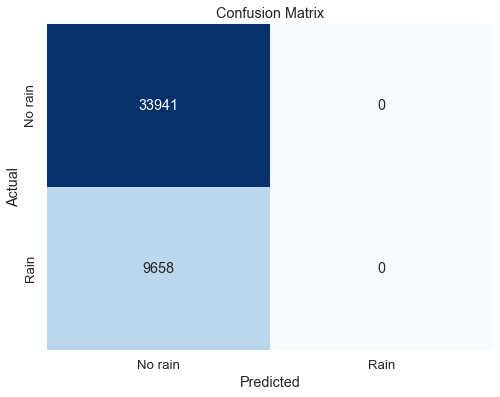

C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


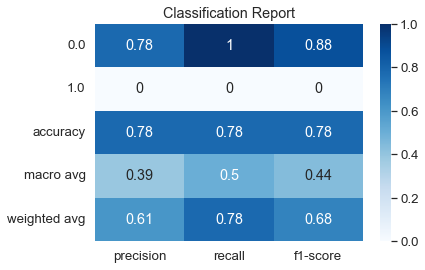

In [37]:
classes = ['No rain', 'Rain']

#Plot confusion matrix
plot_confusion_matrix(y_val, y_predicted, classes, title='Confusion Matrix')

#Classification report
plot_classification_report(y_val, y_predicted, title='Classification Report')

#### ROC curve

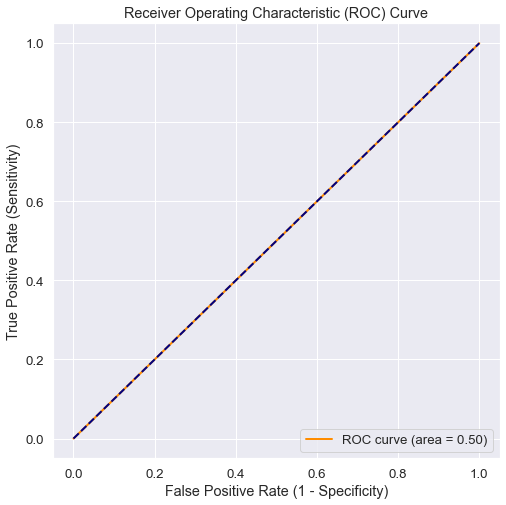

In [40]:
y_probabilities = model.predict_proba(X_sc_val)[:, 1] #Probabilities of positives

fpr, tpr, thresholds = roc_curve(y_sc_val, y_probabilities) #Fail positive rate and true positive rate

roc_auc = auc(fpr, tpr) #Area under ROC curve

#Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<br>
<br>
<br>
<br>
<br>

#### Save model

In [ ]:
ubi = r'C:\Users\Lucio\Documents\Github\Next-day-rain-prediction\3- Models/XGBClf_rain_pred.joblib'

joblib.dump(model, ubi)